In [1]:
# load and autoreload
from IPython import get_ipython
# noinspection PyBroadException
try:
    _magic = get_ipython().magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass
    

import os 
import glob
import sys
import pprint
import datetime as dt
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt 
import xarray as xr 
import seaborn as sns
import cartopy as crt

In [21]:
    F = '../data/CHC_cumbre_15M_2018 -01.txt'

    df = pd.read_csv(F,sep='\s+',skiprows=15)

In [22]:
df

,YYYY,MM,DD,HH,mm,WS,WD,WDstdv,Tair,RH,Pbar
0,2018,1,1,0,0,0.54,81.1,58.7,0.60,38.97,535.0
1,2018,1,1,0,15,2.30,195.5,9.9,0.10,50.23,535.0
2,2018,1,1,0,30,3.17,208.9,15.5,-1.19,90.50,535.0
3,2018,1,1,0,45,3.87,213.8,8.7,-1.33,91.40,535.0
4,2018,1,1,1,0,2.94,226.6,14.7,-0.99,85.20,534.2
...,...,...,...,...,...,...,...,...,...,...,...
1353,2018,1,31,18,45,3.24,238.0,8.3,1.43,89.60,533.5
1354,2018,1,31,19,0,6.17,219.0,10.1,-0.28,98.10,533.7
1355,2018,1,31,19,15,6.43,211.1,8.9,-0.78,99.80,533.7
1356,2018,1,31,19,30,5.67,233.1,14.1,-0.69,99.10,533.7


In [23]:

def get_presL():
    F = '../data/CHC_ICOS_471_2018_01.dat'

    df = pd.read_csv(F,sep='\t')
    df['DT'] = pd.to_datetime(df['dateok'])


    df1 = df.set_index('DT')
    df1 = df1.rename({'AP':'P','AT':'T'},axis=1)
    
    df1.index = df1.index  - pd.Timedelta(hours=4)
    df1 = df1[['P','T','RH','WS']]
    df2 = df1.resample('15T',label='right').mean()
    df3 = df2.resample('1T',label='right').mean().interpolate(limit=15)
    return df3

def read_summit():
    F = '../data/CHC_cumbre_15M_2018 -01.txt'

    df = pd.read_csv(F,sep='\s+',skiprows=15)

    dt = df[['YYYY', 'MM', 'DD', 'HH', 'mm']].rename({'YYYY':'Year','MM':'Month','DD':'Day','HH':'Hour','mm':'Minute'},axis=1)


    df.index=pd.to_datetime(dt)

    df1 = df.rename({'Tair':'T','Pbar':'P'},axis=1)[['T','RH','P','WS']]

    df2 = df1[(df1>-999)&(df1<999)]

    df3 = df2.resample('15T').mean()
    df3 = df3.resample('1T',label='right').mean().interpolate(limit=15)
    return df3 

def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

def cross_corr(V, dfm):
    res = {}
    for i in range(-120, 120):
        res[i] = crosscorr(dfm[V + 's'], dfm[V + 'i'], i)
    res = pd.Series(res)
    return res


def plot_ts(ax, dfm,V):
    dfm.plot(ax=ax)
    ax.set_title(V)


def merge_data(V, dfI, dfS):
    dfm = pd.merge(dfS[[V]], dfI[[V]], left_index=True, right_index=True, suffixes=['s', 'i'])
    return dfm


def plot_cross_val(V, ax, res):
    delta_t = res.index[res.argmax()]
    res.plot(ax=ax)
    ax.set_title(f'{V} [cross-correlation]')
    ax.set_xlabel('time delta [minutes]')
    ax.set_ylabel('correlation')
    ax.axvline(delta_t, c='.5')
    ax.text(delta_t, np.mean(res), f' {delta_t=}')

In [24]:
PATH = './imgs2'

In [25]:
!mkdir {PATH}

mkdir: ./imgs2: File exists


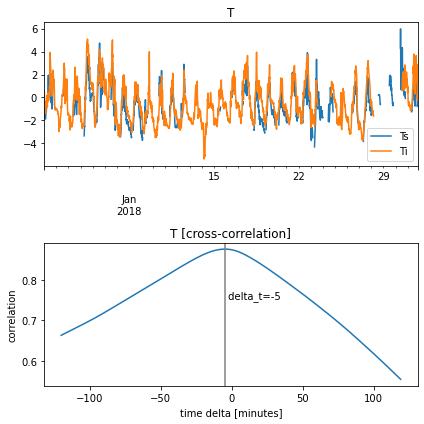

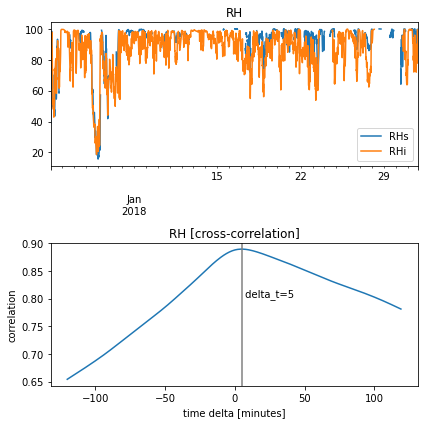

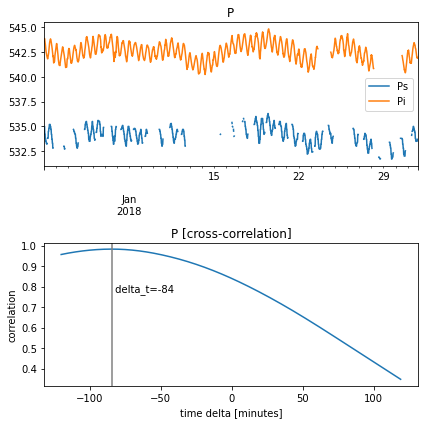

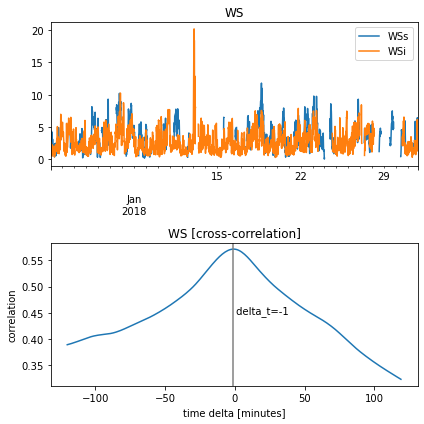

In [26]:
dfI = get_presL()

dfS = read_summit()



for V in ['T','RH','P','WS']:

    dfm = merge_data(V, dfI, dfS)
    res = cross_corr(V, dfm)

    f, (ax1,ax2) = plt.subplots(2,1,figsize=(6,6))
    plot_ts(ax1, dfm, V)

    plot_cross_val(V, ax2, res)
    f.tight_layout()
    f.savefig(f'{PATH}/{V}.png')